# Leg reversion study
---

In [258]:
from data_pre_processing import *
from pair_finder import *
from back_tester import *
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression


## Data
---

In [259]:

#BTC and WBTC
#-------------------------------------------
#prices = pd.read_csv("binance_data/Wrapped BTC/2024/1m/merged_closing_prices.csv", index_col=0, parse_dates=True)


#SOL and BNSOL
#-------------------------------------------
#prices = pd.read_csv('binance_data/SOL_and_BNSOL/2025/1m/merged_closing_prices.csv', index_col=0, parse_dates=True)

#ETH and WBTC
#-------------------------------------------
#prices = pd.read_csv('binance_data/ETH_and_WBETH/2024/1m/merged_closing_prices.csv', index_col=0, parse_dates=True)

#Top 100
#-------------------------------------------
#prices = pd.read_csv('binance_data/top_100_tickers/2024/1m/merged_closing_prices.csv', index_col=0, parse_dates=True)

In [260]:
#prices = prices[['XRP/USDT_2024_1m', 'ADA/USDT_2024_1m']]

#prices = prices[['DOT/USDT_2024_1m', 'XTZ/USDT_2024_1m']]

#BCH/USDT_2024_1m & DOGE/USDT_2024_1m
#-------------------------------------------
#prices = prices[['BCH/USDT_2024_1m', 'DOGE/USDT_2024_1m']]

#GALA/USDT_2024_1m & GRT/USDT_2024_1m,0.0056584346126191745,-4.071777010162084
#-------------------------------------------
prices = prices[['GALA/USDT_2024_1m', 'GRT/USDT_2024_1m']]

In [261]:
#Filter prices from January 2024 to March 2024
#-------------------------------------------

prices = prices.loc['2024-01-01':'2024-03-31']


## Params
---

In [262]:
#Params:
window_size = 1440
entry_threshold= 3 #3 was prev
exit_threshold= 0
stop_loss_threshold = 100

## Investigation
---

In [263]:
sym1, sym2 = prices.columns
print(f"\nTesting strategy on pair: {sym1} and {sym2} ...")
S1 = prices[sym1]
S2 = prices[sym2]

# Compute the spread series and beta_series 
spread_series, beta_series, alpha_series = compute_spread_series(S1, S2, window_size)
#print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

# Compute rolling z-score using the provided helper function.
zscore_series, rolling_mean, rolling_std = compute_rolling_zscore(spread_series, window_size)

#                                   FOR CLOSING PRICE DATA
#------------------------------------------------------------------------------------------
# Generate trading signals (positions) based on the spread's z-score
positions, trade_entries, trade_exits = backtest_pair_rolling(spread_series,S1,S2,zscore_series, entry_threshold, exit_threshold, stop_loss_threshold)



Testing strategy on pair: WBETH/USDT_2024_1m and ETH/USDT_2024_1m ...
Total trades closed: 817 (Wins=817, Losses=0)
Win rate: 1.00


In [264]:
initial_capital = 10_000.0
#tx_cost= 0.00031 #0.031% transaction cost
tx_cost= 0.00025 #0.025% transaction cost #Binance level 5 Maker Cost

trade_profits, cumulative_profit_series, entry_times, exit_times = simulate_strategy_trade_pnl(trade_entries, trade_exits, initial_capital, beta_series, tx_cost)

Trade Num: 0
-----------------------------------------------
Trade type: -1, Entry time: 2024-01-03 00:03:00, Exit time: 2024-01-03 00:05:00
Net Trade profit (includes fees): 29.31315034386342
Beta at entry (Not the absolute value): 1.0081901958875625
Notional S1: 4979.608017446916, Notional S2: 5020.391982553083, Shares S1 : 2.0483784522611748, Shares S2: 2.1285203624786773
Percentage change S1: -0.73%, Percentage change S2: -0.04%
Trade Num: 1
-----------------------------------------------
Trade type: -1, Entry time: 2024-01-03 00:09:00, Exit time: 2024-01-03 00:17:00
Net Trade profit (includes fees): 12.106282306189843
Beta at entry (Not the absolute value): 1.0060829078156188
Notional S1: 4984.838842422912, Notional S2: 5015.161157577087, Shares S1 : 2.0561632619281585, Shares S2: 2.124870205988038
Percentage change S1: -0.32%, Percentage change S2: 0.02%
Trade Num: 2
-----------------------------------------------
Trade type: -1, Entry time: 2024-01-03 00:25:00, Exit time: 2024-0

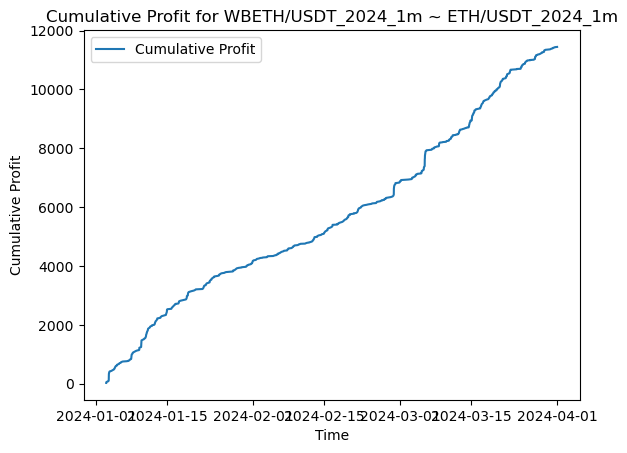

In [265]:
plt.plot(cumulative_profit_series, label='Cumulative Profit')
plt.title(f"Cumulative Profit for {sym1} ~ {sym2}")
plt.xlabel('Time')
plt.ylabel('Cumulative Profit')
plt.legend()

In [266]:
#Compute non-stop loss win rate

trade_losses = [profit for profit in trade_profits if profit < 0]
trade_wins = [profit for profit in trade_profits if profit > 0]


if(stop_loss_threshold > 50):

    print(f"Average trade wins: {np.mean(trade_wins):.2f}")
    print(f"Average trade losses: {np.mean(trade_losses):.2f}")
    print(f"Number of wins: {len(trade_wins)}")
    print(f"Number of losses: {len(trade_losses)}")
    non_stop_loss_win_rate = len(trade_wins) / (len(trade_wins) + len(trade_losses)) * 100
    print(f"Non-stop loss win rate: {non_stop_loss_win_rate:.2f}%")



Average trade wins: 14.01
Average trade losses: nan
Number of wins: 817
Number of losses: 0
Non-stop loss win rate: 100.00%


/Users/alex_1/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/alex_1/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [267]:
#Percentage changes in S1 and S2 each trade
trade_percentage_changes = []
for entry_time, exit_time in zip(entry_times, exit_times):
    # Calculate percentage change for S1 and S2
    price_change_S1 = (S1[exit_time] - S1[entry_time]) / S1[entry_time] * 100
    price_change_S2 = (S2[exit_time] - S2[entry_time]) / S2[entry_time] * 100
    trade_percentage_changes.append((price_change_S1, price_change_S2))

#Average absolute percentage change in S1 and S2
average_absolute_percentage_changes = [abs(s1+s2)/2 for s1, s2 in trade_percentage_changes]

#Compute abs trade profits 
abs_trade_profits = [abs(profit) for profit in trade_profits]
#Compute average trade profits

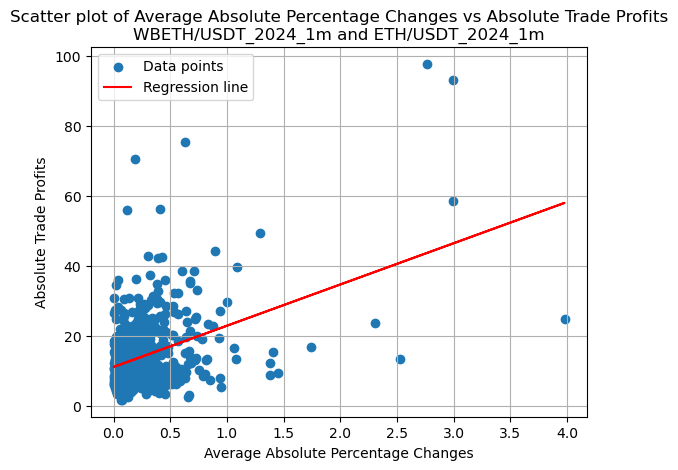

Correlation between average absolute percentage changes and absolute trade profits: 0.4164


In [268]:
#Scatter plot for average_absolute_percentage_changes vs abs_trade_profits with regression line

# Fit a linear regression model
X = np.array(average_absolute_percentage_changes).reshape(-1, 1)
y = np.array(abs_trade_profits)
model = LinearRegression()
model.fit(X, y)
# Predict y values
y_pred = model.predict(X)
# Plot the scatter plot with regression line
plt.scatter(average_absolute_percentage_changes, abs_trade_profits, label='Data points')
plt.plot(average_absolute_percentage_changes, y_pred, color='red', label='Regression line')
plt.xlabel('Average Absolute Percentage Changes')
plt.ylabel('Absolute Trade Profits')
plt.title(f'Scatter plot of Average Absolute Percentage Changes vs Absolute Trade Profits\n{sym1} and {sym2}')
plt.legend()
plt.grid()
plt.show()



#Compute correlation between average_absolute_percentage_changes and abs_trade_profits
correlation = np.corrcoef(average_absolute_percentage_changes, abs_trade_profits)[0, 1]
print(f"Correlation between average absolute percentage changes and absolute trade profits: {correlation:.4f}")


In [269]:
#Check Effect Of net Exposure 
beta_series_trades = beta_series[entry_times]

avg_beta = np.mean(beta_series_trades)

if(avg_beta < 1):
    net_exposure = "S1"
else:
    net_exposure = "S2"

print("avg_beta: ", avg_beta)
print(f"Net exposure: {net_exposure}")



avg_beta:  1.0277602309731717
Net exposure: S2


In [270]:
#An example of a trade where you were net long S1 but still made profit due to S2's hedge, where S2 moved more than S1

# Trade type: -1, Entry time: 2024-03-18 03:12:00, Exit time: 2024-03-18 05:41:00
# Net Trade profit (includes fees): 58.2461918883329
# Beta at entry (Not the absolute value): 0.6246522836635335
# Notional S1: 6155.163231267156, Notional S2: 3844.836768732843, Shares S1 : 9871.953859289744, Shares S2: 5721.483286804826
# Percentage change S1: 0.38%, Percentage change S2: 2.26%
# Trade Num: 65

In [272]:
#Check if losses were caused due to losses in leg that you are nex exposed to

positions_trades = list(positions[entry_times])
S1_trade_returns = [percentage_changes[0] for percentage_changes in trade_percentage_changes]
S2_trade_returns = [percentage_changes[1] for percentage_changes in trade_percentage_changes]

net_exposed_return = []

if net_exposure == "S1":
    net_exposed_return = S1_trade_returns
elif net_exposure == "S2":
    net_exposed_return = S2_trade_returns

losses_due_to_exposure = 0

for position, net_exposed_return, trade_profit in zip(positions_trades,net_exposed_return,trade_profits):

    if(position == 1 and net_exposed_return < 0 and trade_profit < 0 or position == -1 and net_exposed_return > 0 and trade_profit < 0):
        losses_due_to_exposure +=1
    
    elif trade_profit < 0 :
        print(f"Position {position}, Net Exposed Return: {net_exposed_return}, Trade Profit: {trade_profit}")

    # elif (position == 1 and net_exposed_return < 0 and trade_profit > 0 or position == -1 and net_exposed_return > 0 and trade_profit > 0):

    #     print(f"Position {position}, Net Exposed Return: {net_exposed_return}, Trade Profit: {trade_profit}")



print(f"Number of trades where losses were due to exposure: {losses_due_to_exposure}")
#print(f"Percentage of losses caused due to exposure: {losses_due_to_exposure / len(trade_losses) * 100:.2f}%")

Number of trades where losses were due to exposure: 0


In [253]:
#get beta series for the trades where beta is greater than or equal to 1
beta_series_trades_one = beta_series[entry_times]
beta_series_trades_one = beta_series_trades[beta_series_trades >= 1]
beta_series_trades_one

timestamp
2024-01-22 18:45:00    1.131627
2024-02-12 15:37:00    1.000093
2024-02-15 11:20:00    1.186250
2024-02-17 20:30:00    1.039362
2024-04-09 12:05:00    1.049697
2024-05-04 13:11:00    1.287490
2024-05-08 14:34:00    1.708336
2024-06-07 00:57:00    1.007912
2024-06-14 14:23:00    1.059876
2024-06-16 06:48:00    2.494567
dtype: float64

In [254]:
len(trade_losses)

47

In [273]:

#Compute beta series returns
beta_series_returns = 

#Volatility of the spread
z_score_spread_std = zscore_series.std()
print(f"Spread Standard Deviation: {z_score_spread_std:.4f}")

Spread Standard Deviation: 54827.8154
Spread Standard Deviation: 1.0272


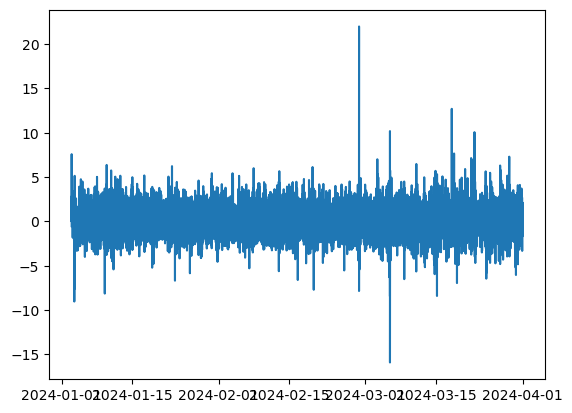

In [274]:
plt.plot(zscore_series)

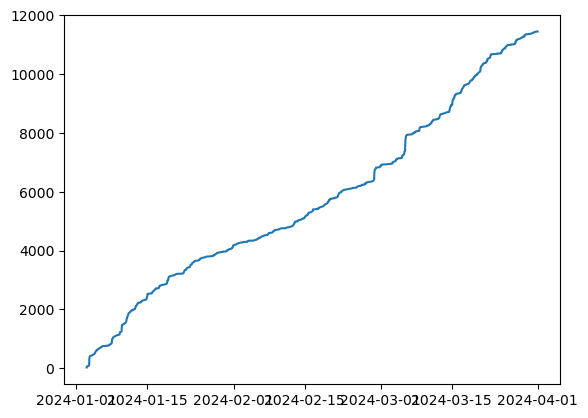

In [276]:
plt.plot(cumulative_profit_series)

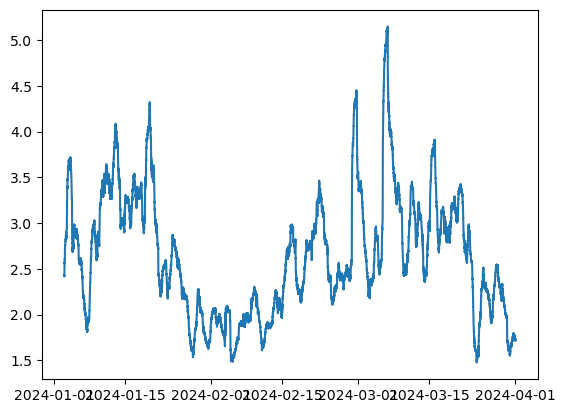

In [275]:
plt.plot(rolling_std)

# Findings From Study
----

In [257]:
#Losses are due to errors in Beta estimation. Prices move more or less than expected under the estimated ratio, leaving you unhedged.
#Large gains and losses are due to increased volatility in each asset. Larger swings in price lead to larger profits and losses.